In [1]:
pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


# get_normalize|

In [5]:
### The function below computes the channel-wise mean and standard deviation for a dataset of images. 
### It takes as input a tensor of shape [N, C, H, W], where N is the number of images, C is the number of channels, 
### and H, W are the image dimensions. 
### The function returns a tuple containing two tensors of length C, representing the mean and standard deviation for each channel.

In [7]:
import torch

def get_normalize(features: torch.Tensor):
    mean = features.mean(dim=(0, 2, 3))  # Mean across N, H, W
    std = features.std(dim=(0, 2, 3))    # Standard deviation across N, H, W

    return mean, std

In [9]:
features = torch.rand(2, 3, 4, 4)

In [11]:
features

tensor([[[[0.0362, 0.9580, 0.4104, 0.3074],
          [0.9362, 0.3683, 0.1119, 0.0237],
          [0.5632, 0.0432, 0.2236, 0.1814],
          [0.8199, 0.0764, 0.1516, 0.9967]],

         [[0.6702, 0.5684, 0.8574, 0.1686],
          [0.2876, 0.5345, 0.0725, 0.0520],
          [0.9305, 0.6724, 0.4083, 0.6824],
          [0.0714, 0.4677, 0.3620, 0.5002]],

         [[0.2210, 0.9570, 0.3801, 0.6822],
          [0.7511, 0.6303, 0.4329, 0.9998],
          [0.7326, 0.1627, 0.6707, 0.0931],
          [0.6007, 0.6105, 0.1882, 0.9412]]],


        [[[0.4185, 0.7010, 0.4041, 0.0777],
          [0.2102, 0.3515, 0.0847, 0.3379],
          [0.9421, 0.5924, 0.2020, 0.1828],
          [0.7068, 0.5093, 0.0308, 0.3448]],

         [[0.8177, 0.9579, 0.9786, 0.4253],
          [0.2403, 0.9963, 0.4462, 0.5653],
          [0.1234, 0.6335, 0.7265, 0.0658],
          [0.6363, 0.6775, 0.8739, 0.3444]],

         [[0.0138, 0.6851, 0.3063, 0.6134],
          [0.1884, 0.9892, 0.9259, 0.1996],
          [0.7014, 0

In [13]:
get_normalize(features)

(tensor([0.3845, 0.5255, 0.5919]), tensor([0.3053, 0.2907, 0.3195]))

# get_augmentations

In [15]:
### Next function returns predefined augmentations for the training and test datasets. 
### It takes a boolean argument indicating whether the augmentations should be for training (True) or testing (False). 
### The transformations include resizing images to 224x224 pixels for both datasets, applying additional augmentations for the training set, 
###converting images to tensors, and normalizing them according to the CIFAR-10 dataset.

In [17]:
import torchvision.transforms as T
from torchvision.transforms import ToTensor

def get_augmentations(train: bool = True) -> T.Compose:
    means = (0.49139968, 0.48215841, 0.44653091)
    stds = (0.24703223, 0.24348513, 0.26158784)
    if train:
        return T.Compose(
            [
                T.Resize((224, 224)),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomAdjustSharpness(sharpness_factor=2),
                T.ToTensor(),
                T.Normalize(mean=means, std=stds)
            ]
        )
    else:
        return T.Compose(
            [
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize(mean=means, std=stds)
            ]
        )

# predict

In [14]:
### Next function performs predictions using a neural network and a data loader on a specified device. 
### It iterates through the data, performs a forward pass for each batch, determines the predicted classes using argmax on the model’s 
### output logits, and stores the results. 
### Finally, it concatenates all predictions into a single tensor of length N, where N is the number of samples in the dataset. 

In [19]:
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()

def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    predictions = []
    model.eval()
    for x, _ in loader:
        x = x.to(device)
        output = model(x)
        predicted_class = torch.argmax(output, dim=1)
        predictions.append(predicted_class)
    return torch.cat(predictions)

# Playing with CNN and CIFAR dataset

In [19]:
class FirstModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 32 x 32 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 16 x 16 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32

            nn.Flatten(),

            nn.Linear(8 * 8 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [21]:
from torchvision.datasets import CIFAR10  # https://www.cs.toronto.edu/~kriz/cifar.html
dataset_train = CIFAR10("../datasets/cifar10", train=True, transform=T.ToTensor())

In [22]:
dataset_train.data.shape

(50000, 32, 32, 3)

In [23]:
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))

means

array([0.49139968, 0.48215841, 0.44653091])

In [26]:
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

stds

array([0.24703223, 0.24348513, 0.26158784])

In [28]:
import torchvision.transforms as T

transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

In [31]:
from torch.utils.data import DataLoader


train_dataset = CIFAR10("../datasets/cifar10", train=True, transform=transforms)
valid_dataset = CIFAR10("../datasets/cifar10", train=False, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

### num_workers - adding 8 processors to load images
### pin_memory=True - makes the training faster

In [24]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

In [35]:
loss_fn = nn.CrossEntropyLoss()

In [35]:
model = FirstModel().to(device)

In [37]:
test_predictions = predict(model, train_loader, device)

In [38]:
test_predictions

tensor([6, 6, 6,  ..., 6, 6, 1])

In [39]:
test_predictions.shape

torch.Size([50000])

In [40]:
train_dataset.data.shape

(50000, 32, 32, 3)

# Predict_tta

In [31]:
### This function implements Test Time Augmentation (TTA) for making predictions with a neural network. 
### It takes a model, a data loader, a device, and a number of iterations. 
### The idea behind TTA is to apply random augmentations to the test dataset multiple times, make predictions for each variation, 
### and average the results before selecting the final predicted classes.

### The function performs the following steps:

### -Iterates over the dataset multiple times, as specified by the iterations parameter.
### -Collects raw model outputs (logits) for each augmented version of the images.
### -Aggregates all logits into a tensor of shape [N, C, iterations], where N is the number of images and C is the number of classes.
### -Averages the logits over the iterations to get a final tensor of shape [N, C].
### -Computes the final class predictions using argmax on the averaged logits.
### -Ensures that gradient computation is disabled and the model is in evaluation mode.

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader



@torch.inference_mode()

def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()
    prediction = []
    for _ in range(iterations):
        single_prediction = []
        model.eval()
        for x, _ in loader:
            x = x.to(device)
            output = model(x)
            single_prediction.append(output)
        prediction.append(torch.vstack(single_prediction))
    stacked_predictions = torch.stack(prediction, dim=0)
    average = torch.mean(stacked_predictions, dim=0)
    
    predicted_class = torch.argmax(average, dim=1)
    return predicted_class

In [65]:
predict_tta(model, train_loader, device)

tensor([8, 8, 3,  ..., 6, 3, 5])

# Simple convolutional neural network - CIFAR dataset

In [ ]:
### training a convolutional neural network with two convolutional layers on the CIFAR-10 dataset, 
### achieving at least 70% accuracy on the test set. 

### While the architecture is limited to two convolutional layers, additional techniques are used.

### The implementation includes:
### -A function named create_simple_conv_cifar that defines and returns the model. This function has no arguments.
### -Generating predictions for the CIFAR-10 test set using the previously defined predict function.
### -Saving the prediction tensor to disk using torch.save.

In [39]:
def create_simple_conv_cifar():
    model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # 32 x 32 x 16
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 16 x 16 x 32
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32

            nn.Flatten(),

            nn.Linear(8 * 8 * 32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    return model

In [44]:
simple_model = create_simple_conv_cifar().to(device)

In [68]:
predict(simple_model, valid_loader, device)

tensor([3, 4, 4,  ..., 4, 3, 3])

In [41]:
import matplotlib.pyplot as plt

In [43]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [45]:
from typing import Tuple

#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> Tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [47]:
#!g1.1
from IPython.display import clear_output

from typing import List

def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    train_accuracy: List[float],
    valid_accuracy: List[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [49]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [51]:
import torch.nn as nn
from torch.optim import Adam

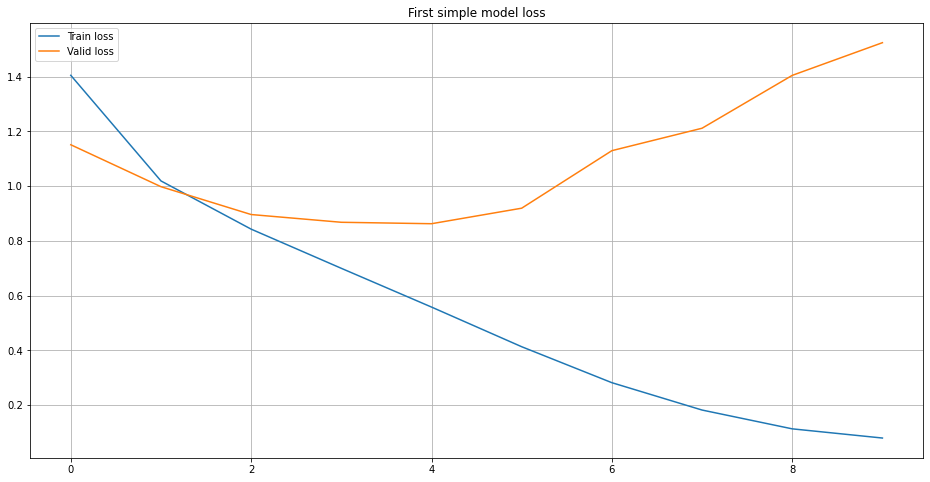

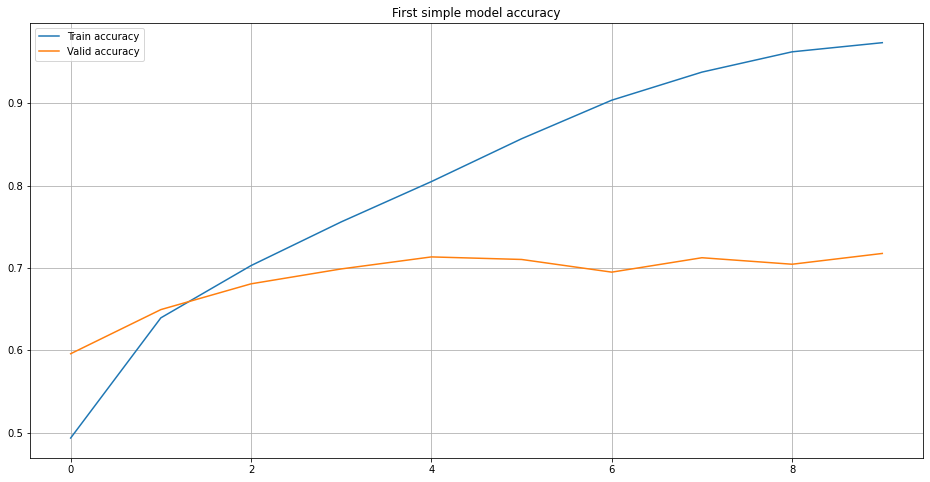

In [74]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

optimizer = Adam(simple_model.parameters(), lr=1e-3)

whole_train_valid_cycle(simple_model, 10, 'First simple model')

In [75]:
predictions = predict(simple_model, valid_loader, device)

In [76]:
torch.save(predictions, "predictions.pt")

# Advanced convolutional neural network - CIFAR dataset

In [ ]:
### This implementation trains a convolutional neural network (CNN) on the CIFAR-10 dataset, achieving at least 85% accuracy on the test set. The model consists of multiple convolutional layers, batch normalization, dropout, and fully connected layers to improve generalization and performance.

### Model Architecture:
### -Two convolutional layers (3×3 kernels, padding=1, ReLU activation)
### -Batch normalization after each convolutional layer
### -Max pooling (2×2) after every two convolutional layers
### -Dropout layers to prevent overfitting
### -Three convolutional blocks with increasing channels: 32 → 64 → 128
### -Fully connected layers: 
### Flatten layer
### Dense layer with 512 neurons (BatchNorm + ReLU + Dropout)
### Final layer with 10 output classes

###The implementation includes:
### -The function create_advanced_conv_cifar, which returns the defined model.
### -Generating predictions using both regular inference (predict) and Test Time Augmentation (predict_tta) to compare their impact on accuracy.
##A test data loader with augmentations specifically for predict_tta.
Saving the final predictions using torch.save.


In [53]:
def create_advanced_conv_cifar():
    model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 16 x 16 x 32
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 16 x 16 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 8 x 8 x 32
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.2),

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    return model



In [55]:
#!g1.1

train_transforms = T.Compose(
    [
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)


train_dataset = CIFAR10("../datasets/cifar10", train=True, transform=train_transforms)
valid_dataset = CIFAR10("../datasets/cifar10", train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

In [62]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [57]:
import torch
print(torch.backends.mps.is_available())

True


In [59]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [ ]:
### without scheduler - low accuracy

advanced_model = create_advanced_conv_cifar().to(device)

optimizer = Adam(advanced_model.parameters(), lr=1e-3)

whole_train_valid_cycle(advanced_model, 20, 'Fourth super advanced model + best learned augmentations')

Train:   5%|█▋                                 | 19/391 [00:17<01:36,  3.87it/s]

In [68]:
predictions = predict_tta(advanced_model, valid_loader, device)

In [69]:
torch.save(predictions, "predictions_2.pt")

In [61]:
#!g1.1

#https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        scheduler.step()

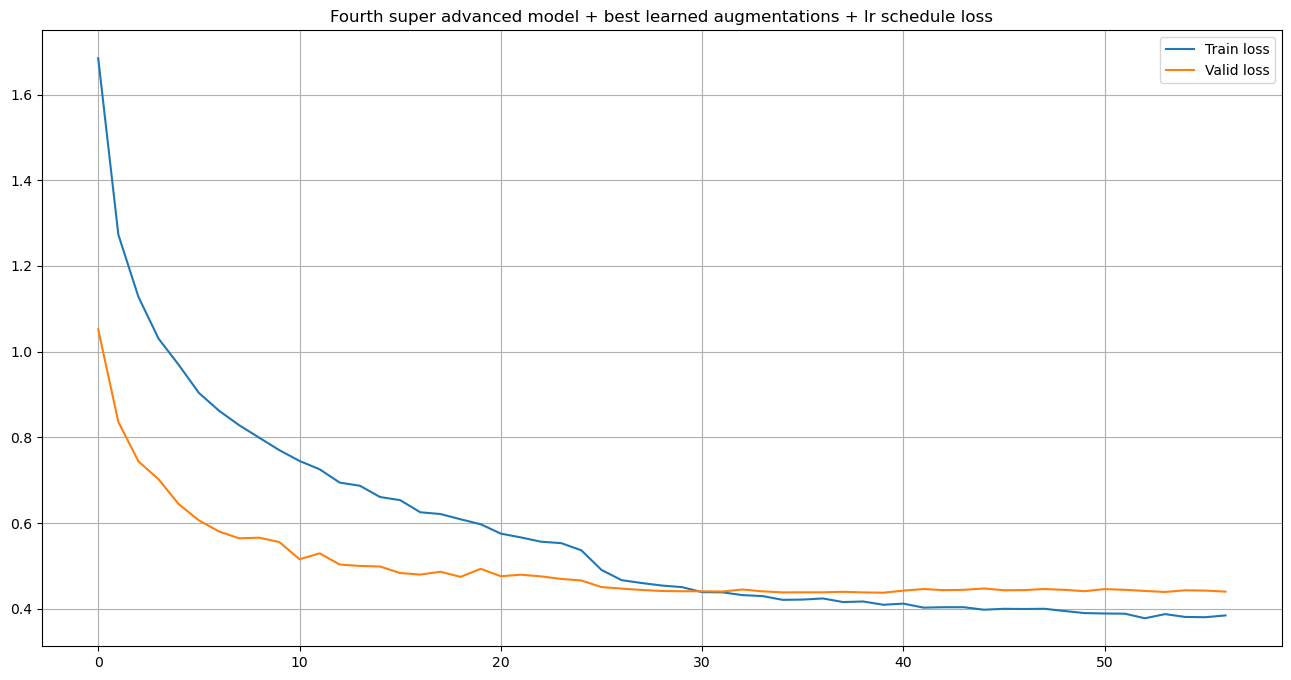

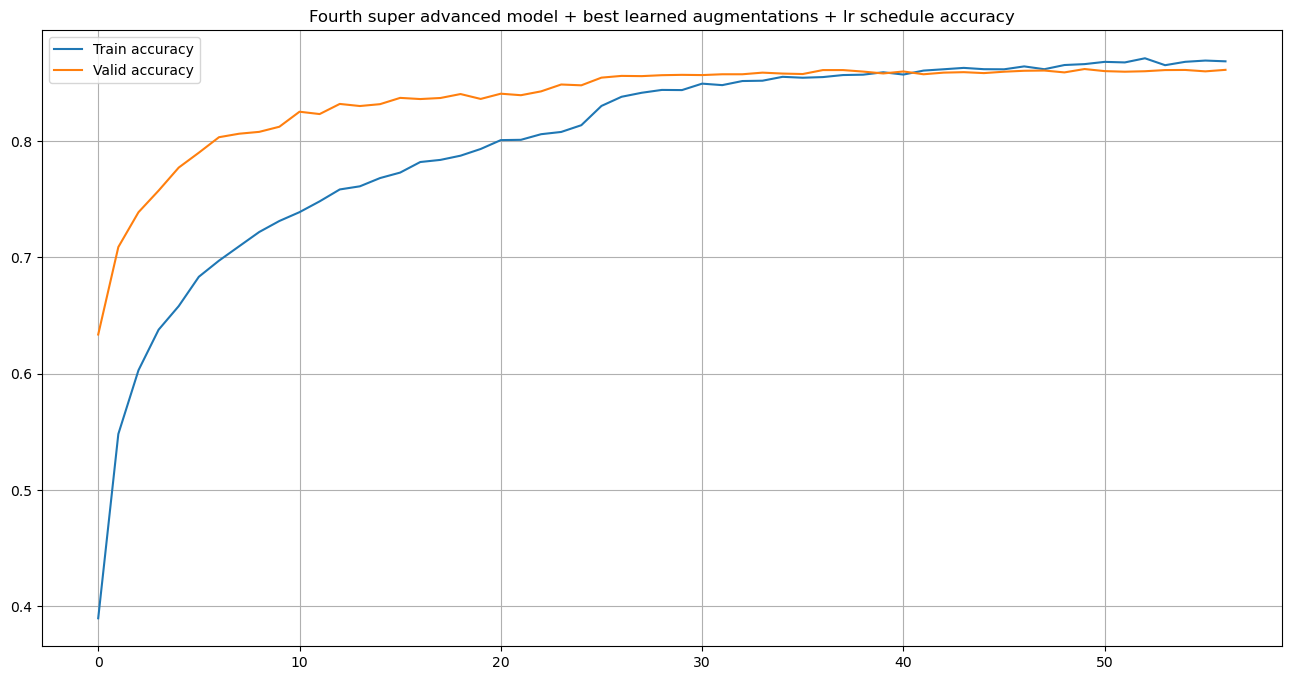

Train:   0%|                                            | 0/391 [00:00<?, ?it/s]

In [ ]:
#!g1.1
from torch.optim.lr_scheduler import StepLR

model = create_advanced_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)

whole_train_valid_cycle_with_scheduler(model, 60, 'Fourth super advanced model + best learned augmentations + lr schedule')

In [75]:
predictions = predict_tta(model, valid_loader, device)

In [76]:
torch.save(predictions, "predictions_4.pt")

In [ ]:
### trying to change the model and the transformer to make the predictions better

In [63]:
def create_advanced_conv_cifar():
    model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),

            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.4),
            nn.ReLU(),

            nn.Linear(512, 10)
        )
    return model

In [65]:

train_transforms = T.Compose(
    [
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)


train_dataset = CIFAR10("../datasets/cifar10", train=True, transform=train_transforms)
valid_dataset = CIFAR10("../datasets/cifar10", train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

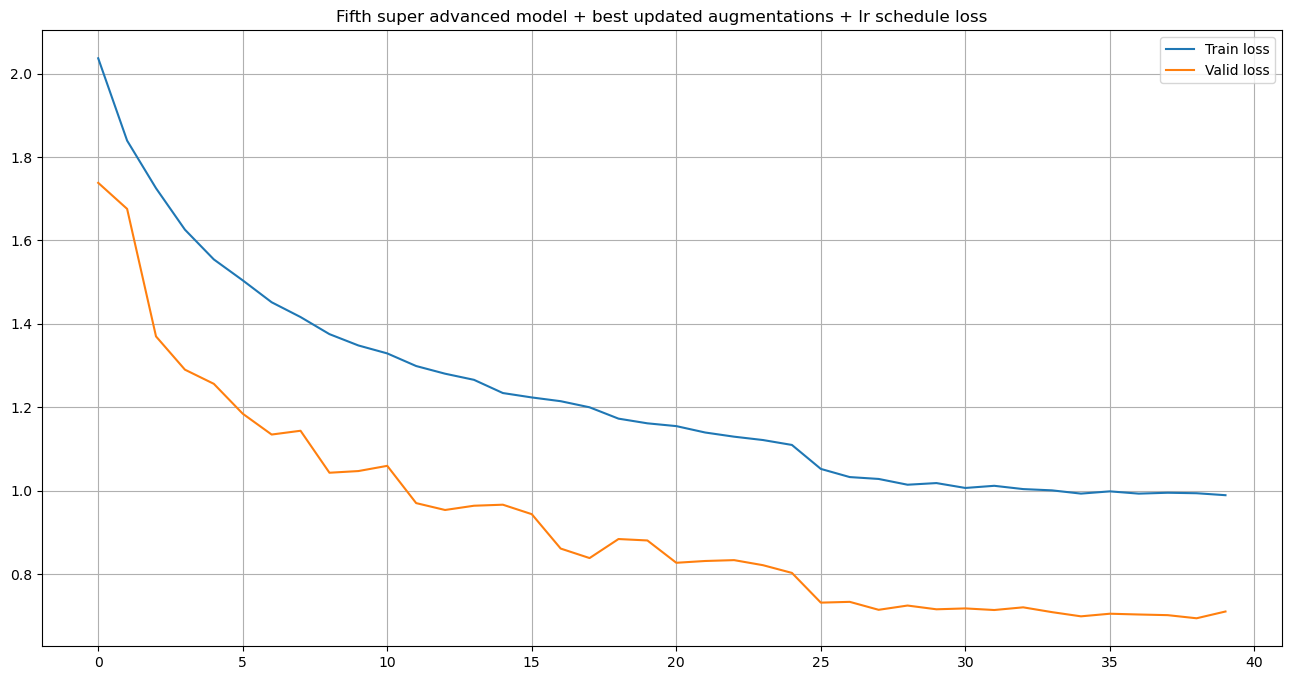

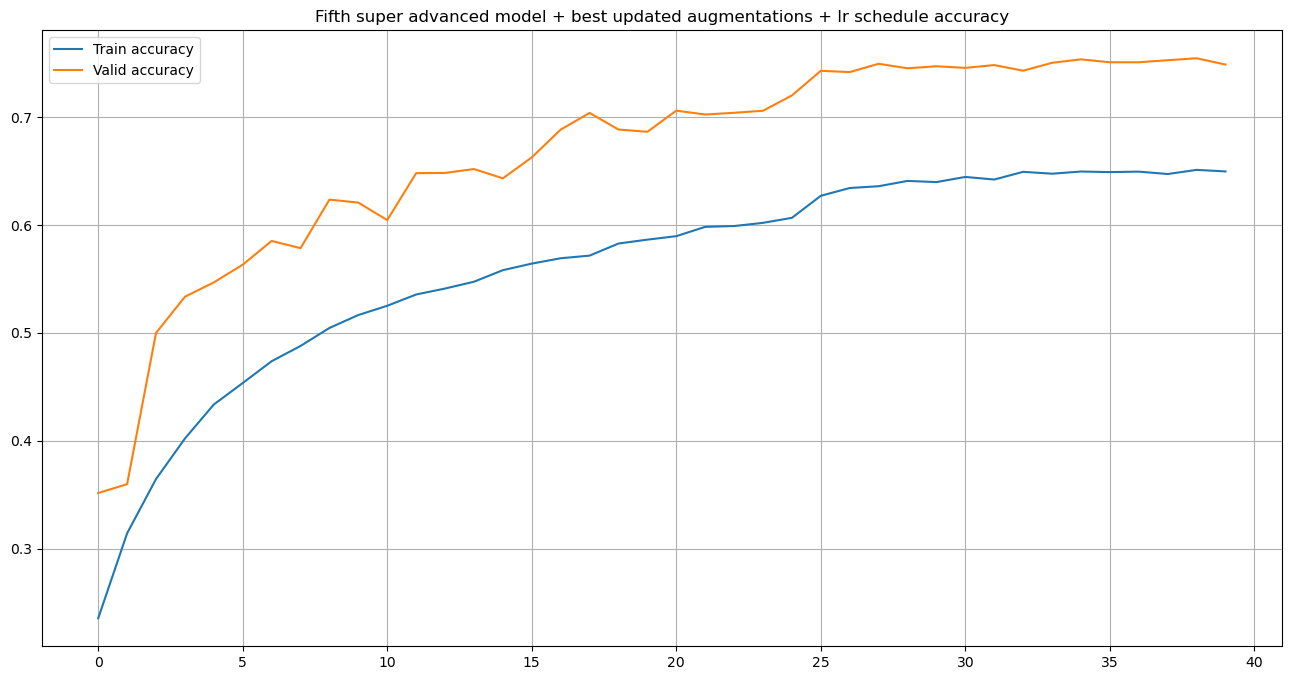

In [67]:
from torch.optim.lr_scheduler import StepLR

model = create_advanced_conv_cifar().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=25)

whole_train_valid_cycle_with_scheduler(model, 40, 'Fifth super advanced model + best updated augmentations + lr schedule')